In [1]:
import matplotlib.pyplot as plt
from scripts.avi_rnn import *

In [19]:
exp_folder = "experiments\\avi"
N = 256
sub_exp = f"N{N}_T128_noisy"
activation = "recttanh"
folder = os.path.join(exp_folder, sub_exp, activation)
exp_list = glob.glob(folder + "/res*")
for exp_i in range(1):
    path = exp_list[exp_i]
    net, result = load_net_path(path)
    net.eval()
exp_i, path

(0,
 'experiments\\avi\\N256_T128_noisy\\recttanh\\result_dict_2024-05-21-16-16-03.pickle')

In [20]:
random_seed = 42
np.random.seed(random_seed)
T=25.6/2
dt=.1 
batch_size=50
from_t=0 
to_t=None
task = angularintegration_task(T=T, dt=dt, sparsity=1, random_angle_init='equally_spaced');
task = angularintegration_task_constant(T=T, dt=dt, speed_range=[0.,0.], sparsity=1, random_angle_init='equally_spaced');
input, target, mask, output, trajectories = simulate_rnn_with_task(net, task, T, '', batch_size=batch_size)

In [21]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(trajectories[:, :, :].reshape(-1, trajectories.shape[2]))
print(pca.explained_variance_ratio_)
traj_pca = pca.transform(trajectories[:, :, :].reshape(-1, trajectories.shape[2])).reshape(-1, trajectories.shape[1], 2)

[0.44227144 0.37001255]


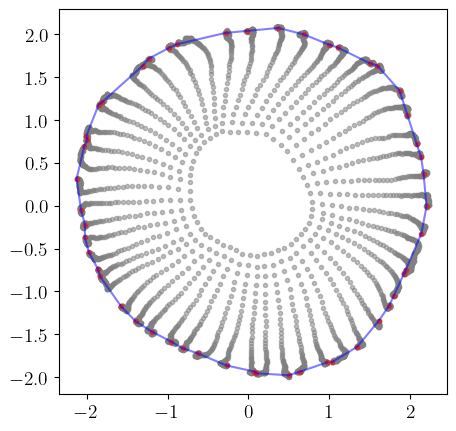

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
from_t = 0
ax.plot(traj_pca[:, from_t:, 0].T, traj_pca[:, from_t:, 1].T, '.', color='gray', alpha=0.5)
ax.plot(traj_pca[:, -1, 0], traj_pca[:, -1, 1], '.', color='red', alpha=0.5)
ax.plot(traj_pca[:, -1, 0], traj_pca[:, -1, 1], '-', color='blue', alpha=0.5)

In [23]:
from torch.utils.data import random_split

from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *
from scripts.ra import *
set_seed(313)
exp_folder = "experiments\\avi"
base_save_dir = 'avi'
save_dir = folder
save_dir

'experiments\\avi\\N256_T128_noisy\\recttanh'

In [ ]:
homeo_type = 'node'
dim = N
layer_sizes = [128]
dt = .1
time_span = torch.tensor([0.0, T-dt/2])
train_ratio = 0.8
analytic = True
vf_on_ring_enabled = True
training_pairs = False
alpha_init = None
velocity_init = None
if training_pairs:
    time_span = torch.tensor([0.0, dt])
ds_motif = 'ring'
ds_params = {
    'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span,
    'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled,
    'alpha_init': alpha_init, 'velocity_init': velocity_init
}
homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': None}
training_params = {'lr': 0.01,'num_epochs': 1000,'annealing_params': {'dynamic': False, 'initial_std': 0.0, 'final_std': 0.0},'early_stopping_patience': 1000,'batch_size': batch_size,'use_inverse_formulation': True}
trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(torch.tensor(trajectories), training_pairs=training_pairs)

train_ratio = 0.8
n_train = int(train_ratio * batch_size)
n_test = batch_size - n_train
train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
trajectories_target_train = trajectories_target[train_set.indices]
trajectories_target_test = trajectories_target[test_set.indices]

# target_ra_points = get_homeo_invman(interpolated_homeo)
target_ra_points = trajectories_target[:, -1, :].reshape(-1, dim)
#target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy()

homeo = build_homeomorphism(homeo_params)
source_system_ra = build_ds_motif(**ds_params)
homeo_ds_net = Homeo_DS_Net(homeo, source_system_ra)
homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(
    homeo_ds_net=homeo_ds_net,
    trajectories_target=trajectories_target_train,
    **training_params
)
homeo_ds_net.eval()

_, _, training_loss = test_single_homeo_ds_net(homeo_ds_net, trajectories_target_train)
_, _, test_loss = test_single_homeo_ds_net(homeo_ds_net, trajectories_target_test)
traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net, trajectories_target)

#fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
#jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1, dim))

In [ ]:
jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target[0,:2,:].reshape(-1, dim), norm_type='spectral', p=1)
jac_norm

Computing Jacobian norms...


tensor(1.4243)

In [ ]:
net_id = path.split("\\")[-1].split("_")[-1].split(".")[0]
net_id, save_dir
hdsn_path = os.path.join(save_dir, f"homeo_ds_net_{net_id}.pth")
save_homeo_ds_net(homeo_ds_net, hdsn_path)

Model saved to experiments\avi\N128_T128_noisy\recttanh\homeo_ds_net_2024-05-21-14-07-21.pth


In [ ]:
fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network, dim=dim)
fit_ra_points = (fit_ra_points ) * std.detach().numpy() + mean.detach().numpy()

In [ ]:
trajectories_source, transformed_trajectories, error = test_single_homeo_ds_net(homeo_ds_net, trajectories_target)
transformed_trajectories = (transformed_trajectories ) * std.detach().numpy() + mean.detach().numpy()

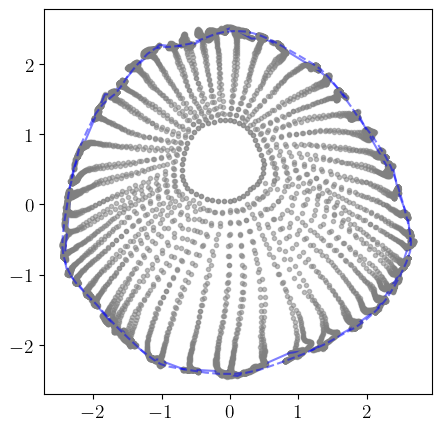

In [ ]:
transformed_traj_pca = pca.transform(transformed_trajectories[:, :, :].reshape(-1, transformed_trajectories.shape[2])).reshape(-1, transformed_trajectories.shape[1], 2)
fit_ra_points_pca = pca.transform(fit_ra_points.reshape(-1, fit_ra_points.shape[-1])).reshape(-1, 2)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
from_t = 0
ax.plot(traj_pca[:, from_t:, 0].T, traj_pca[:, from_t:, 1].T, '.', color='gray', alpha=0.5)
#ax.plot(traj_pca[:, -1, 0], traj_pca[:, -1, 1], '.', color='red', alpha=0.5)
ax.plot(traj_pca[:, -1, 0], traj_pca[:, -1, 1], '-', color='blue', alpha=0.5)


ax.plot(transformed_traj_pca[:, from_t:, 0].T, transformed_traj_pca[:, from_t:, 1].T, '.', color='gray', alpha=0.5)
#ax.plot(transformed_traj_pca[:, -1, 0], transformed_traj_pca[:, -1, 1], '.', color='red', alpha=0.5)
#ax.plot(transformed_traj_pca[:, -1, 0], transformed_traj_pca[:, -1, 1], '--', color='blue', alpha=0.5)
ax.plot(fit_ra_points_pca[:, 0].T, fit_ra_points_pca[:, 1].T, '--', color='blue', alpha=0.5)

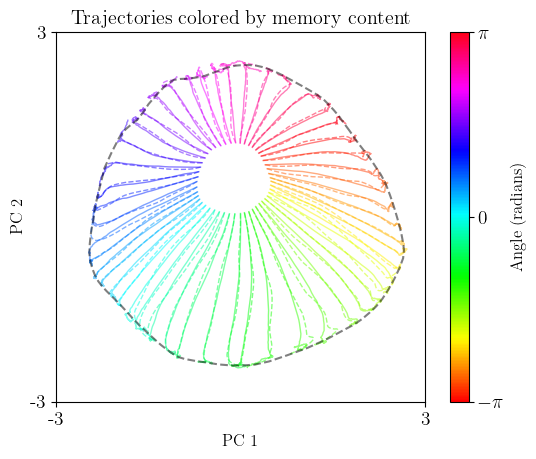

In [ ]:
import matplotlib.ticker as ticker


num_trials = transformed_traj_pca.shape[0]
angles = np.linspace(-np.pi, np.pi, num_trials)

# Colormap setup
cmap_hsv = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(vmin=-np.pi, vmax=np.pi)
colors = cmap_hsv(norm(angles))  # shape: (num_trials, 4)

# Plotting
fig, ax = plt.subplots()
for i in range(num_trials):
    ax.plot(
        traj_pca[i, :, 0],
        traj_pca[i, :, 1],
        color=colors[i],
        alpha=0.5,
        linewidth=1
    )
for i in range(num_trials):
    ax.plot(
        transformed_traj_pca[i, :, 0],
        transformed_traj_pca[i, :, 1],
        linestyle='--',
        color=colors[i],
        alpha=0.5,
        linewidth=1
    )
ax.plot(fit_ra_points_pca[:, 0].T, fit_ra_points_pca[:, 1].T, '--', color='k', alpha=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap_hsv, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Angle (radians)')

# Set custom ticks and format as multiples of π
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda val, pos: {
        -np.pi: r'$-\pi$',
         0: r'$0$',
         np.pi: r'$\pi$'
    }.get(val, f'{val:.2f}'))  # fallback formatting if needed
)

ax.set_title("Trajectories colored by memory content")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
xymm = 3
ax.set_xlim(-xymm, xymm)
ax.set_ylim(-xymm, xymm)
ax.set_xticks([-xymm,xymm], [-xymm,xymm])
ax.set_yticks([-xymm,xymm], [-xymm,xymm])
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, f"traj_pca_{net_id}.pdf"), bbox_inches='tight')
plt.show()

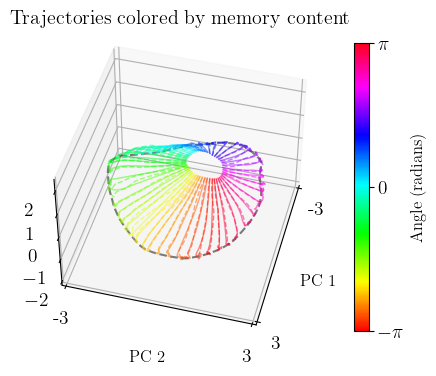

In [ ]:
##3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

pca_dim = 10
pca3 = PCA(n_components=pca_dim)
pca3.fit(trajectories[:, :, :].reshape(-1, trajectories.shape[2]))
traj_pca3 = pca3.transform(trajectories[:, :, :].reshape(-1, trajectories.shape[2])).reshape(-1, trajectories.shape[1], pca_dim)
transformed_traj_pca3 = pca3.transform(transformed_trajectories[:, :, :].reshape(-1, transformed_trajectories.shape[2])).reshape(-1, transformed_trajectories.shape[1], pca_dim)
fit_ra_points_pca3 = pca3.transform(fit_ra_points.reshape(-1, fit_ra_points.shape[-1])).reshape(-1, pca_dim)

num_trials = transformed_traj_pca.shape[0]
angles = np.linspace(-np.pi, np.pi, num_trials)

# Colormap setup
cmap_hsv = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(vmin=-np.pi, vmax=np.pi)
colors = cmap_hsv(norm(angles))  # shape: (num_trials, 4)

# Plotting
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': '3d'})
for i in range(num_trials):
    ax.plot(
        traj_pca3[i, :, 0],
        traj_pca3[i, :, 1],
        traj_pca3[i, :, 2],
        color=colors[i],
        alpha=0.5,
        linewidth=1
    )
for i in range(num_trials):
    ax.plot(
        transformed_traj_pca3[i, :, 0],
        transformed_traj_pca3[i, :, 1],
        transformed_traj_pca3[i, :, 2],
        linestyle='--',
        color=colors[i],
        alpha=0.5,
        linewidth=1
    )
ax.plot(fit_ra_points_pca3[:, 0].T, fit_ra_points_pca3[:, 1].T,  fit_ra_points_pca3[:, 2].T, '--', color='k', alpha=0.5, zorder=-10)

sm = plt.cm.ScalarMappable(cmap=cmap_hsv, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Angle (radians)', shrink=0.75)

# Set custom ticks and format as multiples of π
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda val, pos: {
        -np.pi: r'$-\pi$',
         0: r'$0$',
         np.pi: r'$\pi$'
    }.get(val, f'{val:.2f}'))  # fallback formatting if needed
)

elev = 45
azim = 15
ax.view_init(elev=elev, azim=azim)
ax.set_title("Trajectories colored by memory content")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim(-xymm, xymm)
ax.set_ylim(-xymm, xymm)
ax.set_xticks([-xymm,xymm], [-xymm,xymm])
ax.set_yticks([-xymm,xymm], [-xymm,xymm])
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, f"traj_pca_{net_id}_3d.pdf"), bbox_inches='tight')
plt.show()

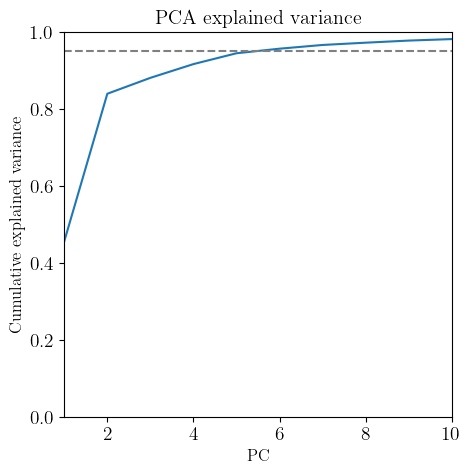

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(range(1, pca_dim+1), np.cumsum(pca3.explained_variance_ratio_))
ax.set_title("PCA explained variance")
ax.set_xlabel("PC")
ax.set_ylabel("Cumulative explained variance")
ax.set_xlim(1, pca_dim)
ax.set_ylim(0, 1)
#ax.set_xticks([1, pca_dim], [1, pca_dim])
ax.axhline(.95, color='gray', linestyle='--')
#ax.set_yticks([0, 1], [0, 1])
#plt.savefig(os.path.join(save_dir, f"pca_explained_variance_{net_id}.pdf"), bbox_inches='tight')

## Loading networks

In [16]:
# hdns_path = 'experiments/avi\\N64_T128_noisy\\recttanh\\homeo_ds_net_2024-05-21-21-17-07.pth'
# homeo = NODEHomeomorphism(dim=64, layer_sizes=[128], activation=nn.ReLU)        
# dynsys = AnalyticalRingAttractor(dim=64, dt = .1, time_span=torch.tensor([0.0, 25.6-.1/2]))
# homeo_ds_net = load_homeo_ds_net(hdns_path, homeo, dynsys)
# homeo_ds_net.invariant_manifold()